In [205]:
#install this agent-based simulation package if you don't have it
# !pip install mesa
from mesa import Agent, Model
from mesa.time import RandomActivation
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [206]:
class DeffuantAgent(Agent):

    def __init__(self, unique_id, model, extremist: bool, mu: float, u: float, u_e: float, op_e: float, p_plus: float, p_minus: float, all=False):
        super().__init__(unique_id, model)
        self.mu = mu
        #all with all model
        self.all = all
        #opinion range = [-1, 1], uncertainty range [0, 1]
        #random opinion and average uncertainty except for some extremists
        if extremist:
            right_or_left = np.random.choice([1, -1], p=[p_plus, p_minus])
            #most positive or negative opinions and a very low level of uncertainty.
            self.opinion = op_e * right_or_left
            self.uncertainty = u_e
        else:
            #random opinion
            self.opinion = random.uniform(-1, 1)
            #average uncertainty
            self.uncertainty = u

    def step(self):
        if self.all:
            agents = [x for x in self.model.schedule.agents if x.unique_id != self.unique_id]
            #formulas from paper 2.3 for all agents that interact with this(self) agent
            for agent in agents:
                overlap = min(agent.opinion + agent.uncertainty, self.opinion + self.uncertainty) - \
                          max(agent.opinion - agent.uncertainty, self.opinion - self.uncertainty)
                non_overlap = 2 * agent.uncertainty - overlap
                agreement = overlap - non_overlap
                relative_agreement = agreement / agent.uncertainty / 2
                if overlap > agent.uncertainty and relative_agreement > 0:
                    #formulas from paper 2.4 for all agents that interact with this(self) agent
                    new_opinion2 = self.opinion + self.mu * relative_agreement * (agent.opinion - self.opinion)
                    new_uncertainty2 = self.uncertainty + self.mu * relative_agreement * (agent.uncertainty - self.uncertainty)
                    self.model.set.append({"id": self.unique_id, "opinion": new_opinion2, "uncertainty":new_uncertainty2})
        else:
            # if agent is in set 1 it will change its opinion with agent from set 2
            index = next((i for i, x in enumerate(self.model.set1) if x == self.unique_id), None)
            # otherwise skip
            if index is None:
                return
            #find 2 agents
            agent1: DeffuantAgent = self
            agent2: DeffuantAgent = next((x for x in self.model.schedule.agents if x.unique_id == self.model.set2[index]), None)
            #formulas from paper 2.3 for agent1
            overlap = min(agent1.opinion + agent1.uncertainty, agent2.opinion + agent2.uncertainty) - \
                      max(agent1.opinion - agent1.uncertainty, agent2.opinion - agent2.uncertainty)
            non_overlap = 2 * agent1.uncertainty - overlap
            agreement = overlap - non_overlap
            relative_agreement = agreement / agent1.uncertainty / 2

            new_opinion1 = None
            new_uncertainty1 = None
            new_opinion2 = None
            new_uncertainty2 = None
            #if overlap is negative it will never be computed
            if overlap > agent1.uncertainty and relative_agreement > 0:
                #formulas from paper 2.4 for agent1
                new_opinion2 = agent2.opinion + self.mu * relative_agreement * (agent1.opinion - agent2.opinion)
                new_uncertainty2 = agent2.uncertainty + self.mu * relative_agreement * (agent1.uncertainty - agent2.uncertainty)

            #formulas from paper 2.3 for agent2
            non_overlap = 2 * agent2.uncertainty - overlap
            agreement = overlap - non_overlap
            relative_agreement = agreement / agent2.uncertainty / 2

            if overlap > agent2.uncertainty and relative_agreement > 0:
                #formulas from paper 2.4 for agent2
                new_opinion1 = agent1.opinion + self.mu * relative_agreement * (agent2.opinion - agent1.opinion)
                new_uncertainty1 = agent1.uncertainty + self.mu * relative_agreement * (agent2.uncertainty - agent1.uncertainty)

            #modify agent values
            if overlap > agent1.uncertainty and overlap > agent2.uncertainty:
                #modify agent values simultaneously
                agent2.opinion = new_opinion2
                agent2.uncertainty = new_uncertainty2

                agent1.opinion = new_opinion1
                agent1.uncertainty = new_uncertainty1
            elif overlap > agent1.uncertainty:
                agent2.opinion = new_opinion2
                agent2.uncertainty = new_uncertainty2

            elif overlap > agent2.uncertainty:
                agent1.opinion = new_opinion1
                agent1.uncertainty = new_uncertainty1



class DeffuantModel(Model):

    def __init__(self, n: int, p_e = 0.1, mu: float = 0.5, u: float = 0.5, u_e: float = 0.1, op_e: float = 0.9, p_plus: float = 0.5, p_minus: float = 0.5, all: bool = False):
        self.num_agents = n
        #active in random order all agents
        self.schedule = RandomActivation(self)
        self.all = all
        self.set1 = []
        self.set2 = []
        self.set = []
        for i in range(self.num_agents):
            #every (1/p_e) agent is extremist
            extremist = i % round(1 / p_e) == 0
            a = DeffuantAgent(i, self, extremist=extremist, mu=mu, u=u, u_e=u_e, op_e=op_e, p_plus=p_plus, p_minus=p_minus, all=self.all)
            self.schedule.add(a)


    def step(self):
        """Advance the model by one step."""
        #choose 2 sets to make pairwise modification
        if not self.all:
            self.set1 = random.sample(range(self.num_agents), self.num_agents // 2)
            self.set2 = list(set( [i for i in range(self.num_agents)] ).difference(set(self.set1)))
            random.shuffle(self.set1)
            random.shuffle(self.set2)
        else:
            for i in range(len(self.schedule.agents)):
                #apply all modifications for all agents that were done in last round
                x = next((x for x in self.set if x["id"] == self.schedule.agents[i].unique_id), None)
                if x is not None:
                    self.schedule.agents[i].opinion = x["opinion"]
                    self.schedule.agents[i].uncertainty = x["uncertainty"]
            self.set = []
        self.schedule.step()

In [207]:
#uncertanties and opinions are default values
#Pairwise version
deffuantModel = DeffuantModel(n=200)
steps = 200
step_opinion = []
#try to run model
for i in range(steps):
    step_opinion.append([agent.opinion for agent in deffuantModel.schedule.agents])
    deffuantModel.step()

In [208]:
#plotting results
def plot_model(deffuantModel, step_opinion):
    plt.figure(figsize=(20,15))
    for i in range(len(deffuantModel.schedule.agents)):
        plt.plot([agent_step[i] for agent_step in step_opinion], label=f"agent {i}")
    plt.xlabel("step")
    plt.ylabel("opinion")
    plt.legend(prop={'size': 9}, ncol=math.ceil(len(deffuantModel.schedule.agents)/50), fancybox=True, bbox_to_anchor=(1, 1))
    plt.show()

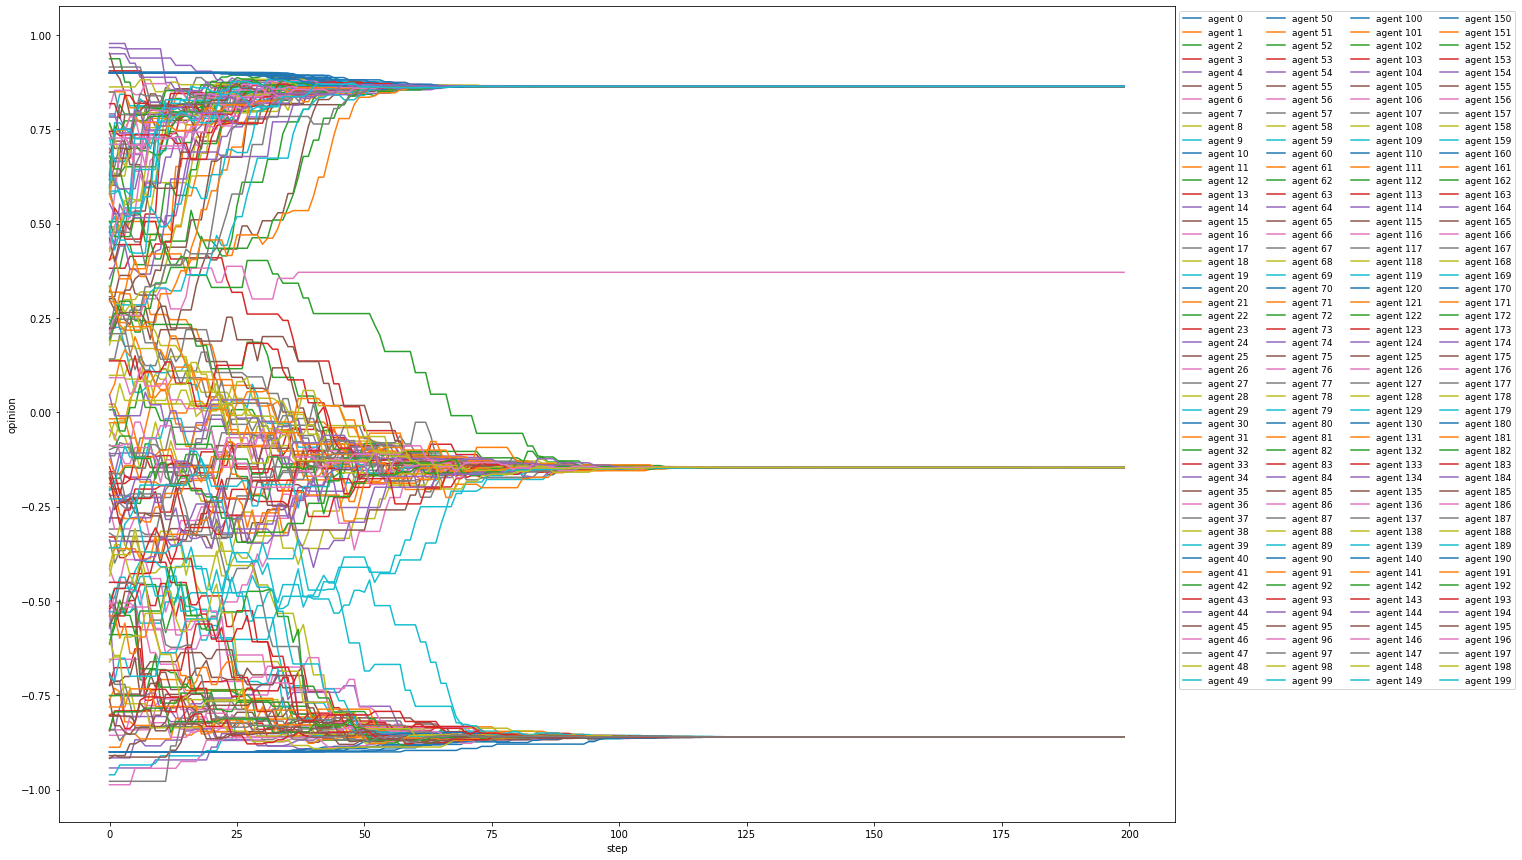

In [209]:
plot_model(deffuantModel, step_opinion)

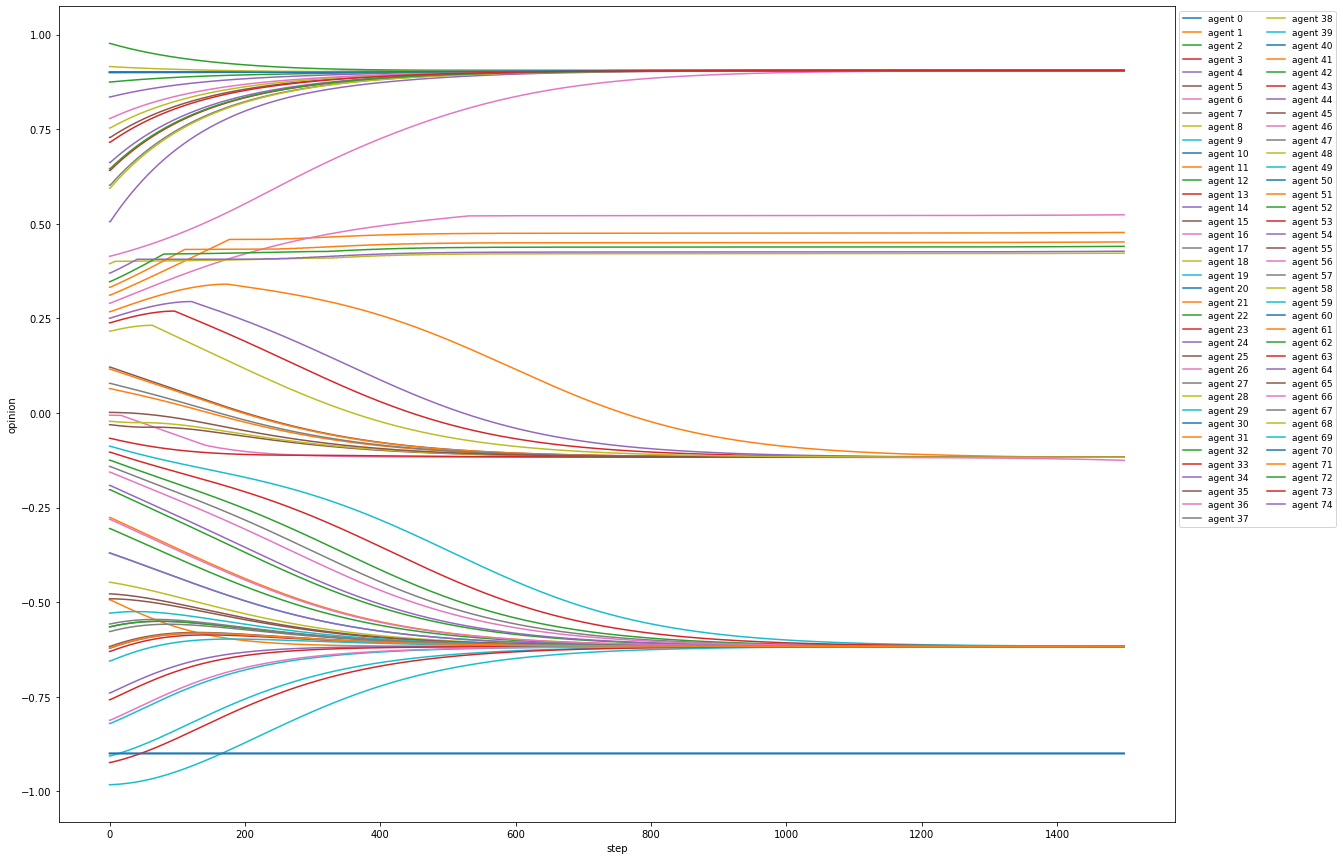

In [283]:
#uncertanties and opinions are default values
#All with all version
N = 75
deffuantModel = DeffuantModel(n=N, all=True, mu=0.5/(N-1))
steps = 1500
step_opinion = []
#try to run model
for i in range(steps):
    step_opinion.append([agent.opinion for agent in deffuantModel.schedule.agents])
    deffuantModel.step()
plot_model(deffuantModel, step_opinion)

In [211]:
#using last values of agent opinions find opinions to which other opinions converge
# and find opinion variance for every cluster
def find_clusters(numbers):
    cluster_epsilon = 0.1

    def grouper(arr):
        #sort and check if last value is less than epsilon. If it is then it is in same cluster, as previous
        iterable = sorted(arr)
        prev = None
        group = []
        for item in iterable:
            if prev is None or item - prev <= cluster_epsilon:
                group.append(item)
            else:
                yield group
                group = [item]
            prev = item
        if group:
            yield group

    clustered = dict(enumerate(grouper(numbers), 1))
    #cluster value = mean of all its agent opinions
    clusters = {i:np.mean(el) for i, el in clustered.items()}
    #cluster value = variance of all its agent opinion
    variance = {i:np.var(el) for i, el in clustered.items()}
    return clusters, variance

In [212]:
find_clusters(step_opinion[-1])

({1: -0.9043491313984258, 2: 0.0683735100857318, 3: 0.8736735439506573},
 {1: 2.5027865212051137e-20,
  2: 1.6449989042385573e-18,
  3: 4.632170032375978e-19})

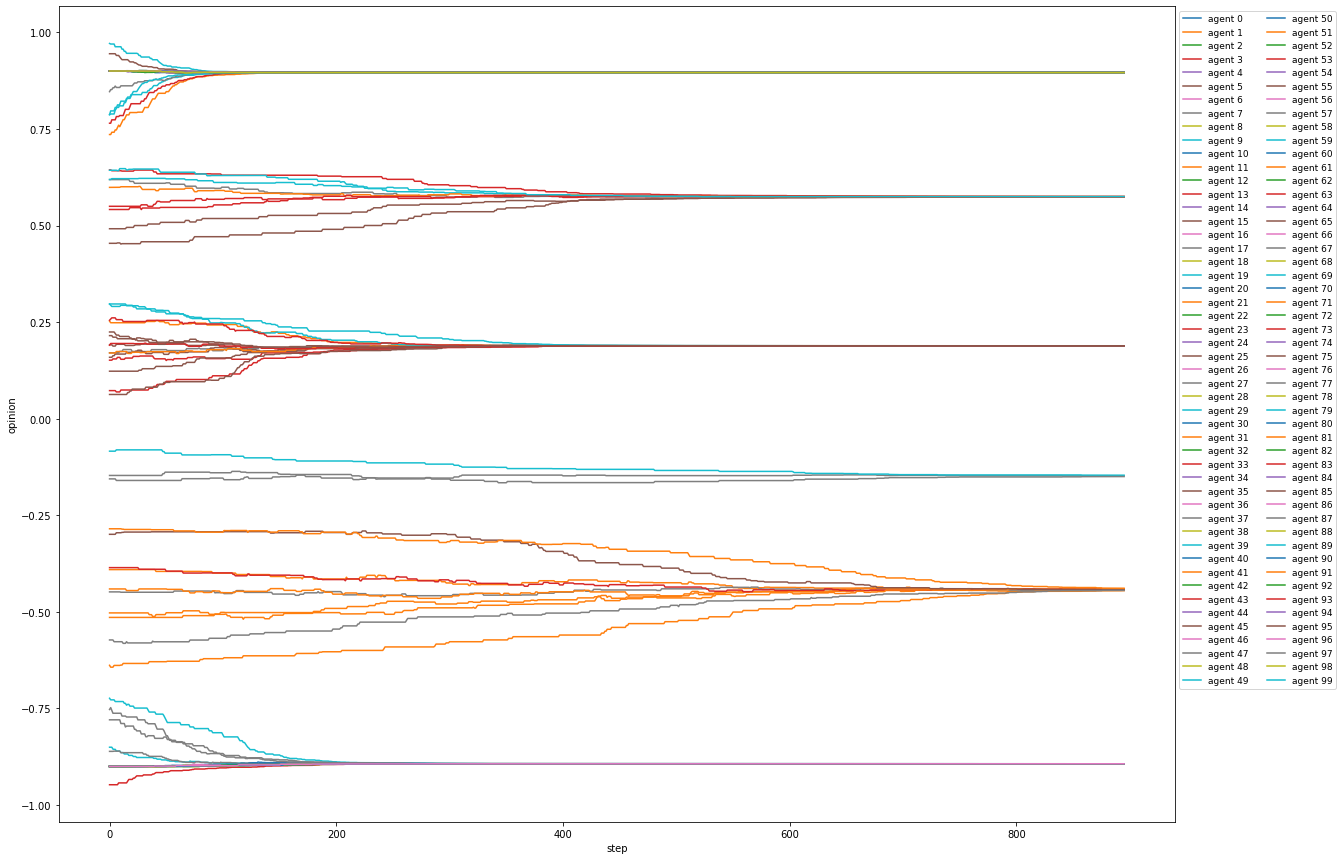

In [58]:
#model convergence based on variance of clusters
deffuantModel = DeffuantModel(n=100, p_e=0.5, mu=0.1, u=0.2, u_e=0.1, p_plus=0.6, p_minus=0.4)
i = 0
step_opinion = []
while True:
    step_opinion.append([agent.opinion for agent in deffuantModel.schedule.agents])
    if i % 10:
        clusters, variance = find_clusters(step_opinion[-1])
        #if variance between agent opinions of some cluster is small enough -> cluster converges
        # if we take average value of all variances and it is very small -> model converges
        if np.mean([variance for variance in variance.values()]) < 1.e-6:
            break
        #if model is not convergent
        if i > 5000:
            #as seen in the plot some clusters are converge to 1 cluster, so we need to think about it
            break
    deffuantModel.step()
    i =+ 1
plot_model(deffuantModel, step_opinion)

In [61]:
divergence_count = 0
divergence_clusters = []
convergence_clusters = []
#loop over all parameters and check for convergence
for p_e in np.linspace(0.1, 0.4, 4):
    for mu in np.linspace(0.2, 1, 5):
        for u in np.linspace(0.3, 1, 8):
                for p_plus in np.linspace(0.1, 1, 10):
                    p_minus = 1 - p_plus
                    u_e = 0.1
                    deffuantModel = DeffuantModel(n=100, p_e=p_e, mu=mu, u=u, u_e=u_e, p_plus=p_plus, p_minus=p_minus)
                    i = 0
                    step_opinion = []
                    while True:
                        step_opinion.append([agent.opinion for agent in deffuantModel.schedule.agents])
                        if i % 10:
                            clusters, variance = find_clusters(step_opinion[-1])
                            #if variance between agent opinions of some cluster is small enough -> cluster converges
                            # if we take average value of all variances and it is very small -> model converges
                            if np.mean([variance for variance in variance.values()]) < 1.e-6:
                                convergence_clusters.append({"clusters":clusters, "step": i, "p_e": p_e, "p_plus": p_plus, "p_minus":p_minus, "u":u, "mu":mu, "u_e": u_e})
                                break
                            #if model is not convergent
                            if i > 2500:
                                clusters.update({"p_e": p_e, "p_plus": p_plus, "p_minus":p_minus, "u":u, "mu":mu, "u_e": u_e})
                                divergence_clusters.append(clusters)
                                divergence_count += 1
                                break
                        deffuantModel.step()
                        i += 1
#divergent percent(diverge=not converge to 2500 step)
#divergent percent=0 if we change last step from 2500 to 5000, but it will take more time and 2.8% of divergence is insignificant
divergence_count / (4*5*8*10)
#converge = distribution of all agent opinions close to clusters have average variance(grouped by clusters) lower than 0.000001
#example
#variances of opinions of clusters:
#1: 0.1
#2: 0.2
#3: 0.2
#4 0.3
#mean variance=0.2>0.000001 -> diverge

0.028125

In [60]:
#example of convergence_clusters, will be used in ML model, but mu will not be used
convergence_clusters[0]

{'clusters': {1: -0.8767818470058836,
  2: -0.40022800835763556,
  3: 0.3707848573059418,
  4: 0.8261861154948044},
 'step': 462,
 'p_e': 0.1,
 'p_plus': 0.1,
 'p_minus': 0.9,
 'u': 0.3,
 'mu': 0.2}

In [95]:
dataset = []
#prepare dataset for ML model
#loop over all parameters and check for convergence
for p_e in np.linspace(0.1, 0.4, 4):
    for u in np.linspace(0.4, 0.8, 5):
        for u_e in [0.01, 0.1]:
            for p_plus in np.linspace(0.1, 1, 10):
                for j in range(30):
                    p_minus = 1 - p_plus
                    deffuantModel = DeffuantModel(p_e=p_e, u=u, u_e=u_e, p_plus=p_plus, p_minus=p_minus)
                    i = 0
                    step_opinion = []
                    while True:
                        step_opinion.append([agent.opinion for agent in deffuantModel.schedule.agents])
                        if i % 10:
                            clusters, variance = find_clusters(step_opinion[-1])
                            if np.mean([variance for variance in variance.values()]) < 1.e-6:
                                dataset.append({"clusters":len(clusters), "step": i, "p_e": p_e, "p_plus": p_plus, "p_minus":p_minus, "u":u, "u_e": u_e})
                                break
                            #if model is not convergent
                            if i > 5000:
                                break
                        deffuantModel.step()
                        i += 1

In [ ]:
import json
#save dataset in file
outputfilename = "dataset.json"
with open(outputfilename, 'w') as outfile:
    json.dump(dataset, outfile)

In [213]:
#load dataset
data = None
with open(outputfilename) as f:
    data = json.load(f)

In [214]:
df = pd.DataFrame(data).drop("step", axis=1)
#drop unnecessary column
df

,clusters,p_e,p_plus,p_minus,u,u_e
0,5,0.1,0.1,0.9,0.4,0.01
1,3,0.1,0.1,0.9,0.4,0.01
2,3,0.1,0.1,0.9,0.4,0.01
3,3,0.1,0.1,0.9,0.4,0.01
4,3,0.1,0.1,0.9,0.4,0.01
...,...,...,...,...,...,...
11995,2,0.4,1.0,0.0,0.8,0.10
11996,2,0.4,1.0,0.0,0.8,0.10
11997,2,0.4,1.0,0.0,0.8,0.10
11998,2,0.4,1.0,0.0,0.8,0.10


In [215]:
#highest correlation for set
df["clusters"].corr(df["u"])

-0.4807194344968598

In [270]:
#finding formula for highest similarity
norm_product = pd.DataFrame(df.drop("clusters", axis=1).apply(lambda x:  np.cosh(x.sum()) * x["u"]**-2 /((x**2).sum()), axis=1), columns=["product/norm"])
#merging for finding correlation
df_norm_product = df[["clusters"]].merge(norm_product, left_index=True, right_index=True)
df_norm_product["clusters"].corr(df_norm_product["product/norm"])

0.5398271485483231

In [271]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
#split dataset
X_train, X_test, y_train, y_test = train_test_split(df.drop(["clusters"], axis=1), df["clusters"], train_size=0.7, test_size=0.3, random_state=0)

In [272]:
#choose classifier
#GradientBoostingClassifier have shown best results for prediction
clf = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.1, max_depth=3).fit(X_train, y_train)

In [273]:
y_pred = clf.predict(X_test)
#print accuracy of classifier(77.25%)
#with formula accuracy is (77.139%)
accuracy_score(y_test, y_pred)

0.7725

In [274]:
#model which based only on similarity formula
X_train, X_test, y_train, y_test = train_test_split(df_norm_product.drop(["clusters"], axis=1), df_norm_product["clusters"], train_size=0.7, test_size=0.3, random_state=0)
clf = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.1, max_depth=3).fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.7713888888888889